In [6]:
from data import wiki
from data import corpus
import alignment

import nltk
import pandas as pd
import pickle
from tqdm import tqdm_notebook as tqdm

tqdm().pandas()

posts = wiki.load_posts()
pairs = corpus.get_reply_pairs(posts)
users = wiki.load_users(posts=posts)
network = wiki.load_network(reply_pairs=pairs, recreate=False)

df = pd.merge(posts, users, left_on='user', right_index=True)

Reading conversations file.: 100%|██████████| 516766/516766 [00:09<00:00, 57365.71it/s]


Filtered 7827 posts from blank or missing users


In [7]:
threshold = users.centrality.mean() + users.centrality.std()
users['highly_central'] = (users['centrality'] > threshold)
df['highly_central'] = (df['centrality'] > threshold)

In [9]:
if not 'tokens' in posts:
    posts = corpus.tokenize_posts(posts)

Tokenizing posts.: 100%|██████████| 383467/383467 [04:09<00:00, 1539.89it/s]


Filtered 6544 posts with 0-length utterances


In [5]:
if not 'pos_tags' in posts:
    pos_tags = posts.tokens.progress_apply(nltk.pos_tag)
    posts['pos_tags'] = pos_tags.progress_apply(lambda x: [y[1] for y in x])
    wiki.save_posts(posts, overwrite=True)

In [22]:
import time
import os

data_dir = 'word_language_model/data/wikitalk_{}'

def write_data(data_dir, posts):

    def write_file(filename, ids):
        path = os.path.join(data_dir, filename)
        with open(os.path.join(data_dir, filename), 'w') as f:
            for i, idx in enumerate(ids):
                tokens = posts.loc[idx].tokens
                f.write(' '.join(tokens)+'\n')
        print("Wrote {} posts to {}".format(i, path))

    if not os.path.exists(data_dir):
            os.mkdir(data_dir)

    post_ids = list(posts.index)
    random.shuffle(post_ids)
    reserved_percent = 20
    n_test_posts = int(reserved_percent/2/100 * len(post_ids))
    n_valid_posts = int(reserved_percent/2/100 * len(post_ids))

    write_file('valid.txt', post_ids[:n_valid_posts])
    write_file('test.txt',  post_ids[n_valid_posts:n_valid_posts+n_test_posts])
    write_file('train.txt', post_ids[n_valid_posts+n_test_posts:])
    

write_data(data_dir.format('tiny_sample'), posts.head(1000))
write_data(data_dir.format('all'), posts)
for year in range(2006,2012):
    write_data(data_dir.format(year), posts[posts.year == year])

Wrote 99 posts to word_language_model/data/wikitalk_tiny_sample/valid.txt
Wrote 99 posts to word_language_model/data/wikitalk_tiny_sample/test.txt
Wrote 799 posts to word_language_model/data/wikitalk_tiny_sample/train.txt
Wrote 37691 posts to word_language_model/data/wikitalk_all/valid.txt
Wrote 37691 posts to word_language_model/data/wikitalk_all/test.txt
Wrote 301538 posts to word_language_model/data/wikitalk_all/train.txt
Wrote 4431 posts to word_language_model/data/wikitalk_2006/valid.txt
Wrote 4431 posts to word_language_model/data/wikitalk_2006/test.txt
Wrote 35458 posts to word_language_model/data/wikitalk_2006/train.txt
Wrote 5657 posts to word_language_model/data/wikitalk_2007/valid.txt
Wrote 5657 posts to word_language_model/data/wikitalk_2007/test.txt
Wrote 45269 posts to word_language_model/data/wikitalk_2007/train.txt
Wrote 5515 posts to word_language_model/data/wikitalk_2008/valid.txt
Wrote 5515 posts to word_language_model/data/wikitalk_2008/test.txt
Wrote 44131 posts to

Now we'll create a vocab from the `wikitalk_all` data so that every language model can use the same vocab.

In [63]:
import torch
import torchtext as tt
import dill

text_field = tt.data.Field(lower=True, include_lengths=False)
train, val, test = tt.datasets.LanguageModelingDataset.splits(path='lm_data/wikitalk_all/', 
                train='train.txt', validation='valid.txt', test='test.txt', 
                text_field = text_field)
text_field.build_vocab(train, val, test, max_size=100000)
torch.save(text_field, 'lm_data/wikitalk_all/vocab.dill', pickle_module=dill)

# Training

We use LSTM language models (code based on: https://github.com/pytorch/examples/tree/master/word_language_model)

First, we train the model for the whole corpus:

`python3 lm_train.py --vocab lm_data/wikitalk_all/ --model LSTM --epochs 10 --batch-size 50 --emsize 100 --cuda --data data/wikitalk_all/ --save data/wikitalk_all/model.bin`

Next, we train the language models for each year, with more than 10k posts (2006--2011) and halt training after the first epoch where the validation loss is less than (or equal to) the final validation perplexity (60) of the "global" model.

`python3 lm_train.py --vocab lm_data/wikitalk_all/ --model LSTM --epochs 20 --batch-size 50 --emsize 100 --stop-at-ppl 60 --cuda --data data/wikitalk_2006/ --save data/wikitalk_2006/model.bin`



# Evaluating utterance perplexity

We evaluate the perplexity of each utterance twice:
1. Using the language model trained on data from the year the utterance was made and
2. using the global language model (trained on data from all years)

In [10]:
import torch
import torch.nn as nn
import dill
import os
import torchtext as tt
import math
import nltk
from tqdm import tqdm_notebook as tqdm


text_field = torch.load('lm_data/wikitalk_all/vocab.dill', pickle_module=dill)

id_field = tt.data.Field(sequential=False, use_vocab=False, is_target=False)
length_field = tt.data.Field(sequential=False, use_vocab=False, is_target=False)
fields = [('id', id_field), ('text', text_field), ('length', length_field)]
pad_idx = text_field.vocab.stoi['<pad>']

softmax = nn.Softmax(dim=2)

ppls = {}
for year in list(range(2006,2012)):

    # load data
    year_posts = posts[posts.timestamp.apply(lambda x: x.year) == year]
    examples = [(i, post.tokens, len(post.tokens)) for i, post in year_posts.iterrows() 
                if len(post.tokens) > 1]
    examples = [tt.data.Example.fromlist(e, fields) for e in examples]
    data = tt.data.Dataset(examples, fields)
    data.sort_key = sort_key=lambda x: x.length
    batch_iter = tt.data.BucketIterator(data, batch_size=100, device='cuda', train='false', sort=True)

    # load model
    model = torch.load('lm_data/wikitalk_{}/model.bin'.format(year)).to('cuda')
    model.eval()

    with torch.no_grad():
        for batch in tqdm(batch_iter, desc=str(year)):
            text_len, batch_size = batch.text.shape
            mask = batch.text.clone()
            mask[mask == pad_idx] = 0
            mask[mask != 0] = 1
            mask = mask[0:-1].t().float()
            hidden = model.init_hidden(batch_size)
            log_probs = []
            for i in range(text_len-1):
                input_ = batch.text[i].reshape(1,-1)
                target = batch.text[i+1].reshape(1,-1)
                output, hidden = model(input_, hidden)
                proba = softmax(output).gather(2, target.reshape(1,-1,1))
                log_probs.append(proba.squeeze().log2())
            log_probs = torch.stack(log_probs, dim=1) * mask
            batch_ppls = torch.pow((-1 * log_probs).sum(dim=1) / batch.length.float(), 2)
            ppls.update(dict(zip(batch.id.tolist(), batch_ppls.tolist())))
ppls = {str(key): val for key,val in ppls.items()} # torchtext converts the index to a number..
posts['ppl_year'] = pd.Series(ppls)

In [11]:
wiki.save_posts(posts, overwrite=True)

In [12]:
ppls = {}

# load data
examples = [(i, post.tokens, len(post.tokens)) for i, post in posts.iterrows() 
            if len(post.tokens) > 1]
examples = [tt.data.Example.fromlist(e, fields) for e in examples]
data = tt.data.Dataset(examples, fields)
data.sort_key = sort_key=lambda x: x.length
batch_iter = tt.data.BucketIterator(data, batch_size=100, device='cuda', train='false', sort=True)

# load model
model = torch.load('lm_data/wikitalk_{}/model.bin'.format('all')).to('cuda')
model.eval()

with torch.no_grad():
    for batch in tqdm(batch_iter):
        text_len, batch_size = batch.text.shape
        mask = batch.text.clone()
        mask[mask == pad_idx] = 0
        mask[mask != 0] = 1
        mask = mask[0:-1].t().float()
        hidden = model.init_hidden(batch_size)
        log_probs = []
        for i in range(text_len-1):
            input_ = batch.text[i].reshape(1,-1)
            target = batch.text[i+1].reshape(1,-1)
            output, hidden = model(input_, hidden)
            proba = softmax(output).gather(2, target.reshape(1,-1,1))
            log_probs.append(proba.squeeze().log2())
        log_probs = torch.stack(log_probs, dim=1) * mask
        batch_ppls = torch.pow((-1 * log_probs).sum(dim=1) / batch.length.float(), 2)
        ppls.update(dict(zip(batch.id.tolist(), batch_ppls.tolist())))
ppls = {str(key): val for key,val in ppls.items()} # torchtext converts the index to a number..
posts['ppl_all'] = pd.Series(ppls)

In [13]:
wiki.save_posts(posts, overwrite=True)

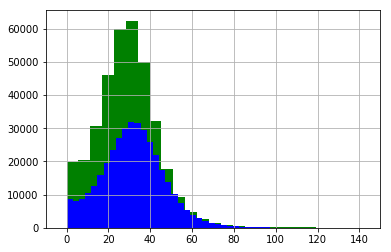

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()
ax.set_xlim(-10, 150)

posts.ppl_year.hist(ax=ax, bins=100, color='Green')
posts.ppl_all.hist(ax=ax, bins=100, color='Blue')
plt.show()

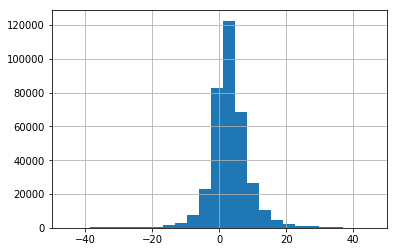

In [44]:
fig, ax = plt.subplots()
ax.set_xlim(-50, 50)
(posts.ppl_all-posts.ppl_year).hist(bins=200, ax=ax)